### Import Libraries

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [19]:
for i in range(1, 4):
    print(i)

1
2
3


### Read in Dataset

In [3]:
df = pd.read_csv('fbdh1.csv')

In [4]:
df.head()

,Flow,D1,D2,P1,P2,dD1,dD2,dP1,dP2
0,-16.69,99.49,-145.71,48.04,-15.90,81.17,12.26,36.71,2.21
1,-16.23,172.78,-118.66,79.84,-11.94,80.09,18.49,35.48,2.91
2,-15.54,242.66,-81.28,109.77,-7.75,75.74,24.65,33.03,3.26
3,-15.17,316.42,-55.50,140.84,-5.30,74.07,28.43,31.89,3.37
4,-14.51,392.40,-31.67,171.92,-1.24,73.96,29.70,31.32,3.68


In [5]:
def label_fix(label):
    if label < -7.5:
        return 0
    elif label > 7.5:
        return 1
    else:
        return 2

df['Class'] = df['Flow'].apply(label_fix)

In [6]:
df.head()

,Flow,D1,D2,P1,P2,dD1,dD2,dP1,dP2,Class
0,-16.69,99.49,-145.71,48.04,-15.90,81.17,12.26,36.71,2.21,0
1,-16.23,172.78,-118.66,79.84,-11.94,80.09,18.49,35.48,2.91,0
2,-15.54,242.66,-81.28,109.77,-7.75,75.74,24.65,33.03,3.26,0
3,-15.17,316.42,-55.50,140.84,-5.30,74.07,28.43,31.89,3.37,0
4,-14.51,392.40,-31.67,171.92,-1.24,73.96,29.70,31.32,3.68,0


In [7]:
def classSwitch(Classes):

    log = []
    decision = []

    for i in range(0, len(Classes)):

        if i > 0:

            if Classes[i] != Classes[i - 1]:
                log.append(i)

                if len(log) > 1 and Classes[log[-1]] != Classes[log[-2] - 1] and Classes[log[-1]] != 2:
                    decision.append(Classes[i])
                    
                elif len(log) > 1 and Classes[log[-1]] == Classes[log[-2] - 1] and Classes[log[-1]] != 2:
                    decision.append(Classes[i])

                elif Classes[i] == 2:
                    decision.append(Classes[i - 1])

            elif Classes[i] == 2:
                decision.append(Classes[log[-1] - 1])

            else:
                decision.append(Classes[i])

        else:
            decision.append(Classes[i])
            
    return decision

In [8]:
df['Class'] = classSwitch(df['Class'])

In [9]:
# Create Function to Gather Data into Overlapping Windows
# Cuts data into size compatible with window length and step size
# Gathers data into results output
# Takes the mode of the classes for each window and saves in classes output

def windowData(df, windowSize, stepSize):
    
    df.reset_index(drop = True, inplace = True)
    new_data = df
    
    for i in range(len(new_data) - windowSize, len(new_data)):
        
        if (i - windowSize) % stepSize  == 0:
            new_data = df.truncate(after = i - 1)
    
    windf = new_data
    
    length = len(windf['D1'])
    
    results = np.zeros([int((length - windowSize) / stepSize), windowSize, 8])
    classes = np.zeros([int((length - windowSize) / stepSize), 1])
    
    for j in range(0, results.shape[0]):
        
        classData = np.zeros([windowSize, 1])
        
        for i in range(0, windowSize):
            
            results[j][i] = [windf['D1'][i + (j * stepSize)], 
                                 windf['D2'][i + (j * stepSize)], 
                                 windf['P1'][i + (j * stepSize)], 
                                 windf['P2'][i + (j * stepSize)], 
                                 windf['dD1'][i + (j * stepSize)], 
                                 windf['dD2'][i + (j * stepSize)], 
                                 windf['dP1'][i + (j * stepSize)], 
                                 windf['dP2'][i + (j * stepSize)]]
            
            classData[i] = windf['Class'][i + (j * stepSize)]
            
        classes[j] = int(stats.mode(classData)[0])
        
    return results, classes

### Create Feature Matrix / Gather Training and Testing Data

In [10]:
df.head()

,Flow,D1,D2,P1,P2,dD1,dD2,dP1,dP2,Class
0,-16.69,99.49,-145.71,48.04,-15.90,81.17,12.26,36.71,2.21,0
1,-16.23,172.78,-118.66,79.84,-11.94,80.09,18.49,35.48,2.91,0
2,-15.54,242.66,-81.28,109.77,-7.75,75.74,24.65,33.03,3.26,0
3,-15.17,316.42,-55.50,140.84,-5.30,74.07,28.43,31.89,3.37,0
4,-14.51,392.40,-31.67,171.92,-1.24,73.96,29.70,31.32,3.68,0


In [11]:
scaleData = df.drop('Flow', axis = 1)
scaleData.drop('Class', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(scaleData)
scaled_features = scaler.transform(scaleData)

X = pd.DataFrame(scaled_features, columns = df.columns[1:9])
X['Class'] = df['Class']

y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [12]:
trainX, trainY = windowData(X_train, 4, 1)
testX, testY = windowData(X_test, 4, 1)

In [13]:
trainX.shape

(4659, 4, 8)

In [21]:
trainY.shape

(4659, 1)

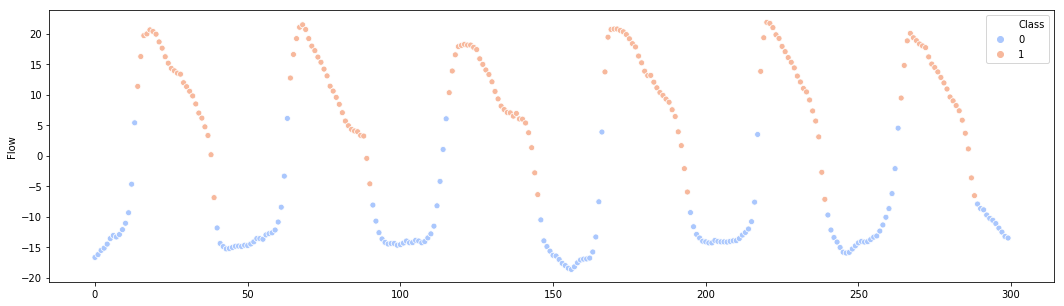

In [22]:
fig = plt.figure(figsize = (18, 5))
sns.scatterplot(y = df['Flow'][0:300], x = range(0, 300), hue = df['Class'][0:300], palette = 'coolwarm')

### Develop LSTM Model

In [53]:
time_steps = trainX.shape[1]
features = trainX.shape[2]

LSTM = keras.Sequential()
LSTM.add(keras.layers.LSTM(175, input_shape = (time_steps, features)))
LSTM.add(keras.layers.Dropout(0.3))
LSTM.add(keras.layers.Dense(50, activation = tf.nn.relu))
LSTM.add(keras.layers.Dropout(0.4))
LSTM.add(keras.layers.Dense(2, activation = tf.nn.softmax))
LSTM.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 175)               128800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 175)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                8800      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 137,702
Trainable params: 137,702
Non-trainable params: 0
_________________________________________________________________


In [54]:
LSTM.fit(trainX, trainY, epochs = 50)

Epoch 1/50
4659/4659 [==============================] - 1s 229us/sample - loss: 0.4025 - acc: 0.8270
Epoch 2/50
4659/4659 [==============================] - 1s 158us/sample - loss: 0.3464 - acc: 0.8433
Epoch 3/50
4659/4659 [==============================] - 1s 153us/sample - loss: 0.3288 - acc: 0.8528
Epoch 4/50
4659/4659 [==============================] - 1s 142us/sample - loss: 0.3129 - acc: 0.8646
Epoch 5/50
4659/4659 [==============================] - 1s 142us/sample - loss: 0.3036 - acc: 0.8598
Epoch 6/50
4659/4659 [==============================] - 1s 147us/sample - loss: 0.2900 - acc: 0.8689
Epoch 7/50
4659/4659 [==============================] - 1s 145us/sample - loss: 0.2794 - acc: 0.8751
Epoch 8/50
4659/4659 [==============================] - 1s 144us/sample - loss: 0.2753 - acc: 0.8787
Epoch 9/50
4659/4659 [==============================] - 1s 147us/sample - loss: 0.2628 - acc: 0.8817
Epoch 10/50
4659/4659 [==============================] - 1s 151us/sample - loss: 0.2504 - a

### Evaluate Model on Testing Split

In [63]:
testX.shape

(1995, 4, 8)

In [64]:
testY.shape

(1995, 1)

In [65]:
predictions = LSTM.predict(testX)

In [66]:
predictions.shape

(1995, 2)

In [67]:
final_pred = []
for score in range(0, len(predictions)):
    final_pred.append(np.argmax(predictions[score]))
    
print(classification_report(testY, final_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1163
         1.0       0.89      0.88      0.89       832

   micro avg       0.91      0.91      0.91      1995
   macro avg       0.91      0.90      0.91      1995
weighted avg       0.91      0.91      0.91      1995



### Test on New Dataset

In [81]:
# Read in dataframe
test = pd.read_csv('test_data_2.csv')
test['Class'] = test['Flow'].apply(label_fix)

test['Class'] = classSwitch(test['Class'])

scaleData_2 = test.drop('Flow', axis = 1)
scaleData_2.drop('Class', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(scaleData_2)
scaled_features = scaler.transform(scaleData_2)

X_1 = pd.DataFrame(scaled_features, columns = df.columns[1:9])
X_1['Class'] = test['Class']
y_1 = test['Class']

newX, newY = windowData(X_1, 4, 1)

In [91]:
test_predictions = LSTM.predict(newX)

final_pred_test = []

for score in range(0, len(test_predictions)):
    final_pred_test.append(np.argmax(test_predictions[score]))
    
print(classification_report(newY, final_pred_test))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      2366
         1.0       0.91      0.85      0.88      2648

   micro avg       0.87      0.87      0.87      5014
   macro avg       0.87      0.87      0.87      5014
weighted avg       0.88      0.87      0.87      5014



In [117]:
del test_predictions

In [121]:
test_predictions = LSTM.predict(newX)

final_pred_test_2 = []

for score in range(0, len(test_predictions)):
    
    if score == 0:
        
        final_pred_test_2.append(np.argmax(test_predictions[score]))
    
    elif score > 0 and np.argmax(test_predictions[score]) > 0.7:
        
        final_pred_test_2.append(np.argmax(test_predictions[score]))
        
    elif score > 0 and np.argmax(test_predictions[score]) < 0.7:
            
        final_pred_test_2.append(final_pred_test[score - 1])
    
print(classification_report(newY, final_pred_test_2))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      2366
         1.0       0.88      0.87      0.88      2648

   micro avg       0.87      0.87      0.87      5014
   macro avg       0.87      0.87      0.87      5014
weighted avg       0.87      0.87      0.87      5014



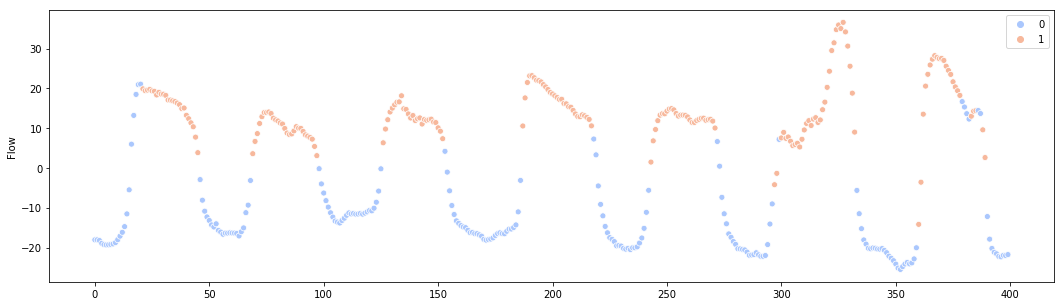

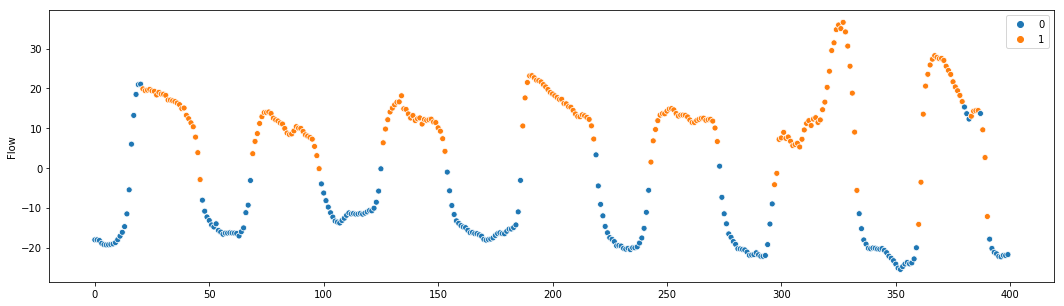

In [122]:
fig = plt.figure(figsize = (18, 5))
sns.scatterplot(y = test['Flow'][0:400], x = range(0, 400), hue = final_pred_test[0:400], palette = 'coolwarm')

fig = plt.figure(figsize = (18, 5))
sns.scatterplot(y = test['Flow'][0:400],x = range(0, 400), hue = final_pred_test_2[0:400])

In [41]:
test_predictions

array([[1.0000000e+00, 2.0162775e-13, 3.4425498e-25],
       [1.0000000e+00, 1.6249221e-12, 2.1760002e-23],
       [1.0000000e+00, 1.1994189e-11, 1.2740340e-21],
       ...,
       [1.3272377e-02, 9.8672765e-01, 2.5571645e-09],
       [2.6207302e-02, 9.7379273e-01, 8.8064134e-09],
       [1.2878526e-04, 9.9987125e-01, 1.2252906e-10]], dtype=float32)